In [ ]:
pip install contractions emoji simpletransformers

In [ ]:
import pandas as pd
import numpy as np
import string
import regex as re
import contractions
import emoji
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from simpletransformers.classification import MultiLabelClassificationModel, ClassificationModel
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt   

In [ ]:
def expand_hashtags ( sentences):
        hashtag_pattern = re.compile (r'#([\p{L}0-9\_]+)')
        return sentences.apply (lambda x: re.sub (hashtag_pattern, lambda match: camel_case_split (match.group (1)), x))

def camel_case_split ( identifier):
        # link https://stackoverflow.com/questions/29916065/how-to-do-camelcase-split-in-python/29920015
        
        matches = re.finditer ('.+?(?:(?<=\p{Ll})(?=\p{Lu})|(?<=\p{Lu})(?=\p{Lu}\p{Ll})|[0-9]+|$)', identifier)
        return ' '.join ([m.group (0) for m in matches])

In [ ]:
def expand_contractions(text):
    return contractions.fix(text)

In [ ]:
def remove_links(s):
    removeLinksPattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',re.DOTALL)
    tmp = re.sub(removeLinksPattern, ' ', s)#, flags = re.DOTALL)
    return tmp 

In [ ]:
def remove_mentions(text):
    begining_mentions_pattern = re.compile (r"^(@[A-Za-z0-9\_]+\s?)+")
    middle_mentions_pattern = re.compile (r'(?<!\b)@([A-Za-z0-9\_]+)\b(?<!user)')
    txt = text.apply (lambda x: re.sub (begining_mentions_pattern, '', x))
    return txt

In [ ]:
def remove_percentages(text):
    percents_pattern = re.compile(r"\b(\d+[\.,]?\d*|\d{2}[AP]M)%")
    #percents_pattern = re.compile(r"(\d+(\.\d+)?%)")
    return text.apply (lambda x: re.sub(percents_pattern, ' ', x))#   re.findall(percents_pattern, text)

def check_percentages(text):
    percents_pattern = re.compile(r"\b(\d+[\.,]?\d*|\d{2}[AP]M)%")
    #percents_pattern = re.compile(r"(\d+(\.\d+)?%)")
    return text.apply (lambda x: re.findall(percents_pattern,  x))#   re.findall(percents_pattern, text)

In [ ]:
def remove_digits (text, replace = '[NUMERO]'):
        digits_pattern = re.compile (r"\b(\d+[\.,]?\d*|\d{2}[AP]M)\b")
        return text.apply (lambda x: re.sub (digits_pattern, replace, x))

In [ ]:
# link https://stackoverflow.com/questions/24893977/whats-the-best-way-to-regex-replace-a-string-in-python-but-keep-its-case
def replace_keep_case (word, replacement, text):
    def func (match):
        g = match.group ()
        if g.islower (): return replacement.lower ()
        if g.istitle (): return replacement.title ()
        if g.isupper (): return replacement.upper ()
        return replacement
    return re.sub (word, func, text)

def remove_elongations (text):
        laughs_pattern = re.compile (r'(?i)\b(mua)?j[ja]+a?\b')
        # Remove laughs
        txt = text.apply (lambda x: re.sub (laughs_pattern, 'jajaja', x))

        
        # Remove exclamatory and interrogative
        for character in ['!', '¡', '?', '¿']:
            pattern = re.compile ('\\' + character + '{2,}')
            txt = txt.apply (lambda x: re.sub (pattern, character, x))
        
        # Add (.)\1{2,}|[aá]{2,}|[eé]{2,}|[ií]{2,}|[oó]{2,}|[uú]{2,})
        elongation_pattern = re.compile (r'(.)\1{2,}')
        # Remove letters longer than 2
        txt = txt.apply (lambda x: re.sub (elongation_pattern, r'\1', x))
        
        txt = txt.apply (lambda x: replace_keep_case (re.compile (r'(?i)[aá]{2,}'), "á", x))
        txt = txt.apply (lambda x: replace_keep_case (re.compile (r'(?i)[eé]{2,}'), "é", x))
        txt = txt.apply (lambda x: replace_keep_case (re.compile (r'(?i)[ií]{2,}'), "í", x))
        txt = txt.apply (lambda x: replace_keep_case (re.compile (r'(?i)[oó]{2,}'), "ó", x))
        txt = txt.apply (lambda x: replace_keep_case (re.compile (r'(?i)[uú]{2,}'), "ú", x))
        return txt

In [ ]:
def remove_emojis (text):
        return text.apply (lambda x: emoji.get_emoji_regexp ().sub (u'', x))

In [ ]:
def remove_quotations (text):
        quotations_pattern = r'["“”\'«»‘’]'
        return text.replace (to_replace = quotations_pattern, value = '', regex = True)

In [ ]:
def remove_punctuation (text):
    punctuation_pattern = re.compile ("[" + re.escape(string.punctuation) + "]")
    #print(punctuation_pattern)
    punc = text.apply (lambda x: re.findall(punctuation_pattern,  x))
    #print(punc)
    return text.apply (lambda x: re.sub (punctuation_pattern, '', x))

In [ ]:
def preprocessData(text):
  txt = expand_hashtags(text)
  txt = txt.apply(lambda x: expand_contractions(x))
  txt = txt.apply(lambda x: remove_links(x))
  txt = remove_mentions(txt)
  txt = remove_percentages(txt)
  txt = remove_digits(txt)
  txt = remove_elongations(txt)
  txt = remove_emojis(txt)
  txt = txt.str.lower()
  txt = remove_quotations(txt)
  txt = remove_punctuation(txt)
  txt = txt.apply(lambda x: x.strip())
  return txt

### **Rishab's work ends here**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = pd.read_csv("/content/drive/My Drive/SEXISM DATA/EXIST2021_training.tsv", sep="\t")
test_data = pd.read_csv("/content/drive/My Drive/SEXISM DATA/EXIST2021_test_labeled.tsv", sep="\t")

In [ ]:
# train_data = train_data.drop(["test_case", "source", "language", "id"], axis = 1)

### **Preprocessing**

In [ ]:
train_data.text = preprocessData(train_data.text)
test_data.text = preprocessData(test_data.text)

In [ ]:
train_data.head(5)

,test_case,id,source,language,text,task1,task2
0,EXIST2021,1,twitter,en,she calls herself antifeminazi how about shut ...,sexist,ideological-inequality
1,EXIST2021,2,twitter,en,now back to these women the brave and the beau...,non-sexist,non-sexist
2,EXIST2021,3,twitter,en,wow your skirt is very short what is it is len...,sexist,objectification
3,EXIST2021,4,twitter,en,incredible beautifulbut i laughed so much whe...,non-sexist,non-sexist
4,EXIST2021,5,twitter,en,i find it extremely hard to believe that kelly...,non-sexist,non-sexist


In [ ]:
test_data.head(5)

,test_case,id,source,language,text,task1,task2
0,EXIST2021,6978,gab,en,pennsylvania state rep horrifies with opening ...,non-sexist,non-sexist
1,EXIST2021,6979,twitter,en,he sounds like as ass and very condescending,non-sexist,non-sexist
2,EXIST2021,6980,twitter,en,lol this behavior of not letting men tell you ...,sexist,ideological-inequality
3,EXIST2021,6981,twitter,en,rightsi mean yeah most women especially the wo...,sexist,ideological-inequality
4,EXIST2021,6982,twitter,en,the jack manifold appreciation i am séing is o...,non-sexist,non-sexist


# TASK - 1

### Taing English data only

In [ ]:
train_data = train_data[train_data.language != 'es']
test_data = test_data[test_data.language != 'es']

In [ ]:
print(train_data.shape, test_data.shape)

(3436, 7) (2208, 7)


### Class size in train data

In [ ]:
train_data.groupby(['task1']).size()

task1
non-sexist    1800
sexist        1636
dtype: int64

### Class size in test data

In [ ]:
test_data.groupby(['task1']).size()


task1
non-sexist    1050
sexist        1158
dtype: int64

### dropping useless columns

In [ ]:
train_data = train_data.drop(["test_case", "source", "language", "id"], axis = 1)
test_data = test_data.drop(["test_case", "source", "language", "id"], axis = 1)

In [ ]:
# train_data = train_data[train_data.task2 != 'non-sexist']

### Creating binary labels for task - 1 for both train and test data

In [ ]:
encoder_task1 = LabelBinarizer()
encoder_task1.fit(train_data['task1'])
transformed = encoder_task1.transform(train_data['task1'])
train_data['label-task-1'] = pd.DataFrame(transformed)

encoder_task1.fit(test_data['task1'])
transformed = encoder_task1.transform(test_data['task1'])
test_data['label-task-1'] = pd.DataFrame(transformed)

In [ ]:
train_data.head(5)

,text,task1,task2,label-task-1
0,she calls herself antifeminazi how about shut ...,sexist,ideological-inequality,1
1,now back to these women the brave and the beau...,non-sexist,non-sexist,0
2,wow your skirt is very short what is it is len...,sexist,objectification,1
3,incredible beautifulbut i laughed so much whe...,non-sexist,non-sexist,0
4,i find it extremely hard to believe that kelly...,non-sexist,non-sexist,0


In [ ]:
test_data.head(5)

,text,task1,task2,label-task-1
0,pennsylvania state rep horrifies with opening ...,non-sexist,non-sexist,0
1,he sounds like as ass and very condescending,non-sexist,non-sexist,0
2,lol this behavior of not letting men tell you ...,sexist,ideological-inequality,1
3,rightsi mean yeah most women especially the wo...,sexist,ideological-inequality,1
4,the jack manifold appreciation i am séing is o...,non-sexist,non-sexist,0


## ROBERTA

In [ ]:
model_roberta_task1_english = ClassificationModel( 'roberta', 'roberta-base', args={'train_batch_size':4, 'learning_rate': 3e-5, 'num_train_epochs': 1, 'max_seq_length': 512, 'overwrite_output_dir': True})


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
model_roberta_task1_english.train_model(train_data[['text','label-task-1']])

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/3436 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/859 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:922: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  model.parameters(), args.max_grad_norm


(859, 0.6160693507255581)

In [ ]:
result, model_outputs, wrong_predictions = model_roberta_task1_english.eval_model(test_data[['text','label-task-1']])

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2208 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/276 [00:00<?, ?it/s]

In [ ]:
result

{'auprc': 0.7830712774362274,
 'auroc': 0.8024627847684842,
 'eval_loss': 0.6618564439856488,
 'fn': 204,
 'fp': 375,
 'mcc': 0.4761258303966185,
 'tn': 675,
 'tp': 954}

In [ ]:
def display_classification_stats(result):
  confusion_matrix = np.zeros((2,2))
  confusion_matrix[0][0] = result['tp']
  confusion_matrix[0][1] = result['tn']
  confusion_matrix[1][0] = result['fn']
  confusion_matrix[1][1] = result['fp']


  precision =  result['tp'] / ( result['tp'] + result['fp'] )
  recall = result['tp'] / ( result['tp'] + result['fn'] )
  F_score =  2 * precision * recall / (precision + recall)
  accuracy = (confusion_matrix[0][0] + confusion_matrix[1][1])/np.sum(confusion_matrix)
  print("ACCURACY  : ", accuracy)
  print("PRECISION : ", precision)
  print("RECALL    : ", recall)
  print("F1        : ", F_score)

  ax= plt.subplot()
  sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

  # labels, title and ticks
  #ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(['sexism', 'non-sexism']); ax.yaxis.set_ticklabels(['sexism', 'non-sexism']);

ACCURACY  :  0.6019021739130435
PRECISION :  0.7178329571106095
RECALL    :  0.8238341968911918
F1        :  0.767189384800965


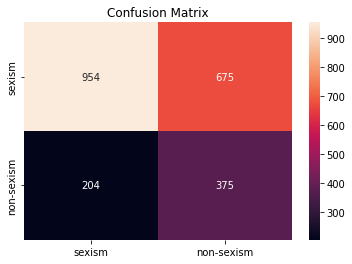

In [ ]:
display_classification_stats(result)

In [ ]:
predictions, raw_outputs = model_roberta_task1_english.predict(test_data['text',])

# TASK-2


In [ ]:
train_data = pd.read_csv("/content/drive/My Drive/SEXISM DATA/EXIST2021_training.tsv", sep="\t")
test_data = pd.read_csv("/content/drive/My Drive/SEXISM DATA/EXIST2021_test_labeled.tsv", sep="\t")

train_data = train_data[train_data.language != 'es']
test_data = test_data[test_data.language != 'es']

train_data = train_data[train_data.task2 != 'non-sexist']
test_data = test_data[test_data.task2 != 'non-sexist']

train_data = train_data.drop(["test_case", "source", "language", "id", "task1"], axis = 1)
test_data = test_data.drop(["test_case", "source", "language", "id", "task1"], axis = 1)

train_data.text = preprocessData(train_data.text)
test_data.text = preprocessData(test_data.text)

In [ ]:
train_data.task2.unique()

array(['ideological-inequality', 'objectification', 'sexual-violence',
       'stereotyping-dominance', 'misogyny-non-sexual-violence'],
      dtype=object)

In [ ]:
test_data.task2.unique()

array(['ideological-inequality', 'objectification',
       'misogyny-non-sexual-violence', 'stereotyping-dominance',
       'sexual-violence'], dtype=object)

In [ ]:
test_data.groupby(['task2']).size()

task2
ideological-inequality          333
misogyny-non-sexual-violence    215
objectification                 150
sexual-violence                 198
stereotyping-dominance          262
dtype: int64

In [ ]:
train_data.groupby(['task2']).size()

task2
ideological-inequality          386
misogyny-non-sexual-violence    284
objectification                 256
sexual-violence                 344
stereotyping-dominance          366
dtype: int64

In [ ]:
test_data.head(5)

,text,task2
2,lol this behavior of not letting men tell you ...,ideological-inequality
3,rightsi mean yeah most women especially the wo...,ideological-inequality
7,stop regarding women as animals who forget tht...,ideological-inequality
8,yeah it is rough but not for women married wom...,objectification
11,you were publicly harassing a girl by constant...,misogyny-non-sexual-violence


In [ ]:
train_data.head(5)

,text,task2
0,she calls herself antifeminazi how about shut ...,ideological-inequality
2,wow your skirt is very short what is it is len...,objectification
5,hellom rajm with gód size and excellent stamin...,sexual-violence
10,you were not actually whatthis is not a painte...,ideological-inequality
15,i do not know any feminists who think the way ...,ideological-inequality


In [ ]:
d = {
    'ideological-inequality'       : 0,         
    'misogyny-non-sexual-violence' : 1,    
    'objectification'              : 2,   
    'sexual-violence'              : 3,   
    'stereotyping-dominance'       : 4   
}

train_data = train_data.replace({"task2": d})
test_data = test_data.replace({"task2": d})


In [ ]:
test_data.head(5)

,text,task2
2,lol this behavior of not letting men tell you ...,0
3,rightsi mean yeah most women especially the wo...,0
7,stop regarding women as animals who forget tht...,0
8,yeah it is rough but not for women married wom...,2
11,you were publicly harassing a girl by constant...,1


In [ ]:
train_data.head(5)

,text,task2
0,she calls herself antifeminazi how about shut ...,0
2,wow your skirt is very short what is it is len...,2
5,hellom rajm with gód size and excellent stamin...,3
10,you were not actually whatthis is not a painte...,0
15,i do not know any feminists who think the way ...,0


In [ ]:
train_data.groupby(['task2']).size()

task2
0    386
1    284
2    256
3    344
4    366
dtype: int64

In [ ]:
test_data.groupby(['task2']).size()

task2
0    333
1    215
2    150
3    198
4    262
dtype: int64

In [ ]:
model_roberta_task2_english = ClassificationModel( 'roberta', 'roberta-base', num_labels=5, args={'train_batch_size':4, 'learning_rate': 3e-5, 'num_train_epochs': 1, 'max_seq_length': 512, 'overwrite_output_dir': True})


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [ ]:
model_roberta_task2_english.train_model(train_data)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1636 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/409 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:922: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  model.parameters(), args.max_grad_norm


(409, 1.2633387372079863)

In [ ]:
result, model_outputs, wrong_predictions = model_roberta_task2_english.eval_model(test_data)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1158 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/145 [00:00<?, ?it/s]

In [ ]:
result

{'eval_loss': 1.0848468122811152, 'mcc': 0.49543083590873555}

In [ ]:
predictions, raw_outputs = model_roberta_task2_english.predict(list(test_data.text.values))

  0%|          | 0/1158 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

In [ ]:
def display_classification_stats_task2(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    target_names = ['ideological\ninequality', 'misogyny\nnon-sexual\nviolence', 'objectification', 'sexual\nviolence', 'stereotyping\ndominance' ]
    target_names2 = ['ideological inequality', 'misogyny non-sexual violence', 'objectification', 'sexual violence', 'stereotyping dominance' ]
    print(classification_report(y_true, y_pred, target_names=target_names2))
    plt.figure(figsize = (15,10))
    ax= plt.subplot()
    sns.heatmap(cf, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    #ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(target_names,rotation=0, fontsize="17")
    ax.yaxis.set_ticklabels(target_names, rotation=0, fontsize="17");

                              precision    recall  f1-score   support

      ideological inequality       0.80      0.62      0.70       333
misogyny non-sexual violence       0.54      0.32      0.40       215
             objectification       0.57      0.41      0.48       150
             sexual violence       0.58      0.82      0.68       198
      stereotyping dominance       0.50      0.73      0.59       262

                    accuracy                           0.60      1158
                   macro avg       0.60      0.58      0.57      1158
                weighted avg       0.62      0.60      0.59      1158



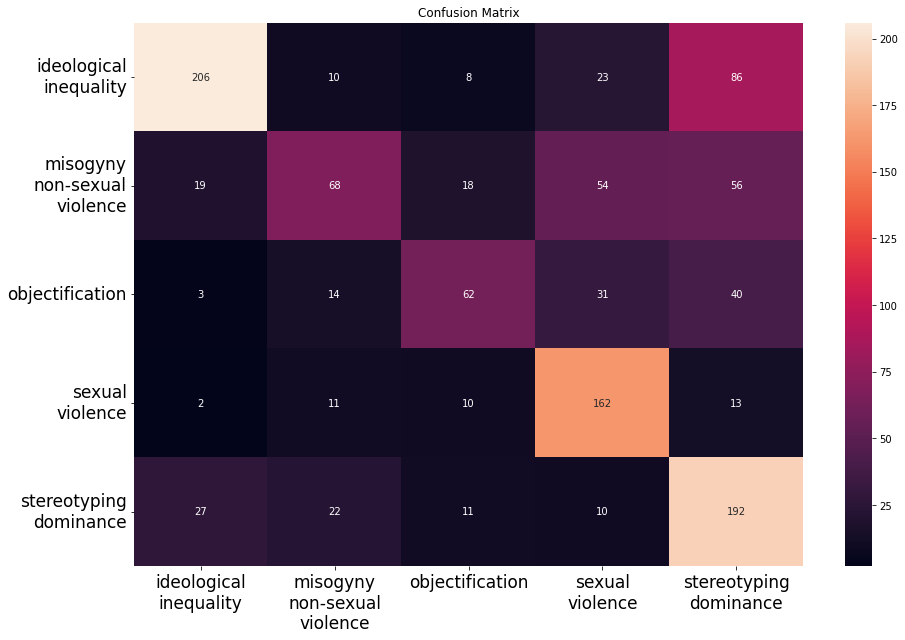

In [ ]:
y_true = test_data.task2.values
y_pred = predictions
display_classification_stats_task2(y_true, y_pred)